# _Data Exercise_

This is a four-part data challenges taken from online questions designed to answer common-day problems existed in the field of Data Science. In this project I used multiple tools including dataframe operations, regression analysis, machine learning models, dimension reduction, etc. 

With detailed explanations of each question, the audience can be guided to walk through the process of every step of the analysis. Enjoy!


## Author: Diyang Wu

## Part 1:


### Question

Arielle and Boris are two chefs competing for flipping pancakes.

The stats from this season are attached in `part1.csv`. The columns are: 

- the contestant's name, 
- the match day, 
- which hand they used to flip the pancakes, 
- their score (how many pancakes they flipped successfully), and 
- how many total pancakes they attempted to flip

Is Arielle or Boris the better pancake flipper? Do both sides have a case here?

### Answer

For this problem, we are interested in identifying the better flipper between Arielle and Boris. We will first calculate some simple statistics to better understand the problem. Then we will determine what tools to be used further to make the conclusion.

In [61]:
# import useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

### 1.1 Read Data

In [2]:
# 1.1 Read data:
pancake = pd.read_csv('coding_exercise_data/part1.csv')
pancake.head()

,match_day,name,hand,score,attempts
0,1,Arielle,R,8,20
1,2,Arielle,R,10,20
2,3,Arielle,R,6,20
3,4,Arielle,L,4,20
4,5,Arielle,R,7,20


### 1.2 Basic statistics and interpretations

In [3]:
# 1.2 Calculation of basic stats to understand the problems:
pancake[pancake['name'] == 'Arielle'].shape[0]
pancake[pancake['name'] == 'Boris'].shape[0]

# There are 50 samples for each of Arielle and Boris

50

In [4]:
# Average success rates for Arielle
avg_prob_A = sum(pancake[pancake['name'] == 'Arielle']['score']) / sum(pancake[pancake['name'] == 'Arielle']['attempts'])
avg_prob_A

0.341

In [5]:
# Average success rates for Boris
avg_prob_B = sum(pancake[pancake['name'] == 'Boris']['score']) / sum(pancake[pancake['name'] == 'Boris']['attempts'])
avg_prob_B

0.338

So now, we have the average rates of successfully flipping the pancakes, which are 0.341 and 0.338 for Arielle and Boris, respectively. However, these two rates are extremely close, making it hard to judge whether Arielle or Boris is a significantly better flipper. In order to further decide who the better flipper is, we need to employ some statistical tests.

### 1.3 Chi-square test

Notice that the number of samples for each group, in this case number of pancake flipping days for each person, is 50, which means that this is a balanced dataset. Also notice that on each day, each person performs 20 attempts, and their successes at flipping are recorded. Thus on each day, the pancake flipping trial can be deemed as a Bionomial distribution. We can employ Chi-square distribution to compare these two different success rates.

The hypothesis test can be formed as followed:

$p_a$: the average success rates of flipping pancakes for Arielle

$p_b$: the average success rates of flipping pancakes for Boris

$H_0: p_a = p_b$

$H_1: p_a \neq p_b$

In [6]:
# 1.3 Perform the chi-sqaure test
ttl_trial =  sum(pancake['attempts'])
ttl_suc = sum(pancake['score'])
ttl_fail = ttl_trial - ttl_suc
AR_suc = sum(pancake[pancake['name'] == 'Arielle']['score'])
BR_suc = sum(pancake[pancake['name'] == 'Boris']['score'])

f_obs = [AR_suc, 50*20-AR_suc, BR_suc, 50*20-BR_suc]
f_exp = (np.array([50*20] * 4) * np.array([ttl_suc, ttl_fail] * 2)) / ttl_trial
chisquare(f_obs, f_exp)


Power_divergenceResult(statistic=0.020067806889724055, pvalue=0.9992484539876503)

As we can see from the output, the p-value is very close to 1, meaning that the probability of obtaining the observed results of the test, assuming that the null hypothesis is true, is very high. If we set our $\alpha$, significance level at 0.05, we reject the null hypothesis and conclude  that there is no significant difference between Arielle and Boris in flipping the pancake.

### 1.4 Linear regression to include `hand` variable

However, one thing to be noticed is that there is another variable included in the dataset called `hand`. It prompts me to think that maybe Arielle or Boris has a preferred hand of flipping pancakes, leading to better performance. 

So I build two linear regression models below on both Arielle and Boris' individual group data to see if they are significantly better with left/right hand. Linear regression is utilized here because it's easier for interpretations.

In [7]:
# 1.4 Using linear regression to judge if `hand` is important.
# encode the categorical variable 'hand'. L is 0 and R is 1.
pancake['hand_cat'] = pancake['hand'].astype('category').cat.codes

# linear regression for Arielle
x_AR = sm.add_constant(pancake[pancake['name'] == 'Arielle'][['hand_cat']])
y_AR = pancake[pancake['name'] == 'Arielle'][['score']]
lr1 = sm.OLS(y_AR, x_AR).fit()
lr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     19.80
Date:                Mon, 10 Feb 2020   Prob (F-statistic):           5.10e-05
Time:                        21:04:57   Log-Likelihood:                -107.05
No. Observations:                  50   AIC:                             218.1
Df Residuals:                      48   BIC:                             221.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8000      0.543      8.847      0.000       3.709       5.891
hand_cat       2.8857      0.648      4.450      0.000       1.582       4.190
==============================================================================
Omnibus:                        0.638   Durbin-Watson:                   2.259
Prob(Omnibus):                  0.727   Jarque-Bera (JB):                0.321
Skew:                          -0.195   Prob(JB):                        0.852
Kurtosis:                       3.049   Cond. No.                         3.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
# linear regression for Boris
x_BR = sm.add_constant(pancake[pancake['name'] == 'Boris'][['hand_cat']])
y_BR = pancake[pancake['name'] == 'Boris'][['score']]
lr2 = sm.OLS(y_BR, x_BR).fit()
lr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     31.61
Date:                Wed, 05 Feb 2020   Prob (F-statistic):           9.42e-07
Time:                        15:49:27   Log-Likelihood:                -106.16
No. Observations:                  50   AIC:                             216.3
Df Residuals:                      48   BIC:                             220.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6857      0.349     16.297      0.000       4.984       6.387
hand_cat       3.5810      0.637      5.622      0.000       2.300       4.862
==============================================================================
Omnibus:                        1.234   Durbin-Watson:                   2.343
Prob(Omnibus):                  0.540   Jarque-Bera (JB):                1.238
Skew:                           0.343   Prob(JB):                        0.538
Kurtosis:                       2.648   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Judging from our results, the p-values for `hand` variable under both models are less than 0.05, suggesting that there is a significant difference in success rates of flipping pancakes when using left or right hand. In particular, the coefficients for `hand` variable are 2.89 and 3.58 for Arielle and Boris respectively. This means that, on average it will improve 2.89 and 3.58 more successes in flipping pancakes using right hand than left hand.

### 1.5 Compare with right-hand performances

Thus, as the final justification, we need to compare Arielle and Boris in terms of their right-hand performance.

In [8]:
# 1.5 Compare Arielle and Boris on their right-hand performance.
pancake['name_cat'] = pancake['name'].astype('category').cat.codes
# 0 is Arielle and 1 is Boris

x = sm.add_constant(pancake[pancake['hand'] == 'R']['name_cat'])
y = pancake[pancake['hand'] == 'R']['score']
lr3 = sm.OLS(y, x).fit()
lr3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     6.411
Date:                Mon, 10 Feb 2020   Prob (F-statistic):             0.0147
Time:                        21:05:00   Log-Likelihood:                -105.16
No. Observations:                  50   AIC:                             214.3
Df Residuals:                      48   BIC:                             218.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6857      0.342     22.474      0.000       6.998       8.373
name_cat       1.5810      0.624      2.532      0.015       0.326       2.836
==============================================================================
Omnibus:                        1.456   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.483   Jarque-Bera (JB):                0.810
Skew:                          -0.287   Prob(JB):                        0.667
Kurtosis:                       3.243   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Thus from the results above, we see that the variable `name_cat` has a p-value of 0.015, which means that if we set the significance level at 0.05, we can conclude that there is a significant difference in success rates for flipping pancakes for Arielle and Boris using their right hands. And on average, Boris can flip 1.58 more pancakes than Arielle using right hands. 

In conclusion, the general performances for Boris and Arielle do not have a significant difference. However, when both of them are using dominant hands, Boris is a better flipper than Arielle. Thus it can be adjustified in some level to say that he's a better flipper than Arielle, since Boris have higher 'upper limit' than Arielle.

## Part 2: Identifying Popular Restaurants from check-ins

A restaurant app has a set of check-ins for restaurants in London, UK and is trying to determine which restaurant is the most popular. They have data in the form of a JSON hash with keys: `user_id, timestamp, place_id, postal_code`.

Using the data in `part2.json`, identify the **most popular** place in each zipcode. Explain your method and your reasoning.


### Answer

### 2.1 Read data

In [9]:
#  2.1 Import the data
restaurant = pd.read_json('coding_exercise_data/part2.json', lines = True)
restaurant.head()

,place_id,postal_code,timestamp,user_id
0,fe2958af-c764-4534-9b68-40e44b77e162,SW15,2018-05-22 03:08:06,f2ada356-3789-4ddb-866f-0e00f3387454
1,f540d154-78d8-4f6a-a07b-ba1082bc94d6,SW18,2018-05-21 03:48:33,3126bb24-0547-4517-bcf8-81f4944832c5
2,b51746ef-a031-4eef-9a37-836b478c9f11,E2,2018-04-23 02:48:06,5df094de-7236-4e06-9e1a-7aeea1910d08
3,b51746ef-a031-4eef-9a37-836b478c9f11,E2,2018-04-23 03:08:46,5df094de-7236-4e06-9e1a-7aeea1910d08
4,39366f8b-ac58-4c4a-9a0f-10121e4f54d3,E2,2018-05-21 04:10:19,08629da4-92e8-434c-932f-5f3b6aa3714c


###  2.2 Find the most popular restaurant based on number of user check-ins

To examine the most popular place for each zipcode, we simply need to count the number of user check-ins for each restaurants, rank them inside of each zipcode, and pick the restaurant with the highest number of user check-ins.

In [10]:
# 2.2 find the most popular restaurant based on number of user check-ins
# calculate the number of user-checkins for each restaurant
df1 = restaurant.groupby(['postal_code', 'place_id'])['user_id'].agg({'num_checkin':'count'})

# reset the index to not include postal_code and place_id in the index
df1.reset_index(inplace = True)

# find the restaurant with highest number of user check-ins for each zipcode
(df1.groupby('postal_code')['place_id', 'num_checkin'].
     apply(lambda x: x.sort_values(['num_checkin'], ascending = False).head(1)))


/Users/diyangwu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,,place_id,num_checkin
postal_code,,,
E2,9,b51746ef-a031-4eef-9a37-836b478c9f11,3180
E4,15,f2f57264-ce10-43d7-a336-0d995dfb02e8,4644
SW15,21,fe2958af-c764-4534-9b68-40e44b77e162,5726
SW18,36,f540d154-78d8-4f6a-a07b-ba1082bc94d6,1480
W6,40,63c97a8b-5d73-4f6e-bb5a-ab8a3cc6e990,1651


The result is provided above.

### 2.3 find the most popular restaurant based on number of unique user check-ins

However, one may argue that, since a user can check in multiple times for a single restaurant, it might be fair to count the number of unique user check-ins for each retaurant. It's true that popularity for a restaurant means it has the ability to engage and retend the customers. However, being able to acquire new customers is also crucial for a restaurant to be popular. Thus we will provide the list of most popular restaurant in each zipcode as followed:

In [173]:
# 2.3 find the most popular restaurant based on number of unique user check-ins
# calculate the number of unique user-checkins for each restaurant
df2 = restaurant.groupby(['postal_code', 'place_id'])['user_id'].nunique()

# reset the index to not include postal_code and place_id in the index
df3 = df2.reset_index()

# find the restaurant with highest number of unique user check-ins for each zipcode
(df3.groupby('postal_code')['place_id', 'user_id'].
   apply(lambda x: x.sort_values(['user_id'], ascending = False).head(1)))


,,place_id,user_id
postal_code,,,
E2,9,b51746ef-a031-4eef-9a37-836b478c9f11,547
E4,15,f2f57264-ce10-43d7-a336-0d995dfb02e8,591
SW15,21,fe2958af-c764-4534-9b68-40e44b77e162,628
SW18,36,f540d154-78d8-4f6a-a07b-ba1082bc94d6,412
W6,40,63c97a8b-5d73-4f6e-bb5a-ab8a3cc6e990,430


The result is provided above. It appears that the number of check-ins indeed drops significantly, but the most popular restaurant within each zipcode remains unchanged judging from the place_de/dataframe index. 

## Part 3: Identifying Popular Restaurants from Tagged Photos

A photo sharing app has a set of photographs tagged to restaurants in London, UK and is trying to determine which are the most popular restaurants in each postal code. The app maker is worried that there may be some skews, biases, and fraud in their data, and has asked you to investigate. Their data, in `part3.json` has the same schema as the data in `part2.json`. 



**Identify what you consider the most popular places, and note any issues with the data. Explain your reasoning.**

### Answer

To answer this question that whether the data has some skews or even fraud, we first need to examine some of the distributions of the variables in the dataset.

We also notice that, for a photo sharing app, a common fraud is that restaurants would hire promoters to give out tags to their restaurants. So we will exmamine distribution of the number of tags made by each user to see if there is ineed such a problem.

### 3.1 Read data

In [116]:
# 3.1 Import data:
restaurant = pd.read_json('coding_exercise_data/part3.json', lines = True)
restaurant.head()

,place_id,postal_code,timestamp,user_id
0,cc4e591f-55d5-458e-a792-bbd78abd7791,W11,1526781194,7533a324-baf6-4ac8-88da-5e6946f78901
1,0f1aa959-dcae-4e5d-bebe-6e8c32d12b50,W11,1522233352,a0221733-4c57-40f9-bffe-afc917ebf1e8
2,0f1aa959-dcae-4e5d-bebe-6e8c32d12b50,W11,1522240001,a0221733-4c57-40f9-bffe-afc917ebf1e8
3,259afbe4-5b34-4d5d-8997-7df0a7b4e4a6,SW14,1521689291,8776aae1-205d-492d-8357-60b06cbce7c9
4,259afbe4-5b34-4d5d-8997-7df0a7b4e4a6,SW14,1521686717,8776aae1-205d-492d-8357-60b06cbce7c9


### 3.2 Exploratory research

/Users/diyangwu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Distribution')

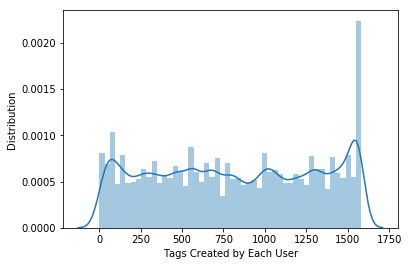

In [118]:
# 3.2 Basic understanding of the data frame
# Transform the user_id to integers for making graphs.
restaurant['user_id'] = restaurant['user_id'].astype('category').cat.codes

# Convert timestamp to datetime
restaurant['timestamp'] = pd.to_datetime(restaurant['timestamp'], unit='s')

sns.distplot(restaurant['user_id'])
plt.xlabel('Tags Created by Each User')
plt.ylabel('Distribution')

Perhaps right from this distribution graph we cannot see clearly if there is a serious skewness in the tags created by each user. However, we do notice that there is some outliers in the upper right corner. We will need to exmaine this in more details.

In [119]:
# Examine the exact numbers of tags created by each user
user_df = restaurant['user_id'].value_counts()
user_df.head(20)

1561    14283
79       2867
661      2233
27       2044
464      1532
254      1487
563      1450
567      1406
576      1361
996      1207
36       1151
1209     1117
278      1113
1197     1105
861      1085
137      1084
780      1083
710       993
722       984
1567      975
Name: user_id, dtype: int64

Apparently user 1561 has over 10,000 tags on this app. Personally I found it very dubious for a user to create that many tags on restaurants. However, one can still argue that, if the user has been around the app long enough, there is a potential that he will give out that many tags. Well, lets check his user active_periods to find out. 

In [120]:
max(restaurant[restaurant['user_id'] == 1561]['timestamp']) - min(restaurant[restaurant['user_id'] == 1561]['timestamp'])

Timedelta('70 days 00:56:14')

Around 70 days! Now I think it's safe to say there is something wrong for this user. The question is, how many other users are potentially dubious, and how should we determine them? 

### 3.3 Identify outliers

To answer this question, we must combine these two pieces of information: the tags created by each user, and the active periods for each user. We can calculate the tags created per day as shown below.

In [124]:
# 3.3 Identify Outliers
# Clean the format for user_df
a = pd.DataFrame(user_df).reset_index()
a.rename(columns = {'index': 'user_id', 'user_id': 'counts'}, inplace = True)

In [125]:
# Calculate the active period for each user and clean the format
b = pd.DataFrame(restaurant.groupby('user_id').apply(lambda a,b: max(a[b]) - min(a[b]), 'timestamp'))
b.reset_index(inplace = True)
b.rename(columns = {0 : 'active_period'}, inplace = True)

In [126]:
# Merge the above dataframe, and transfer the active_period to active_day(0 day counts as 1)
c = pd.merge(a, b, how = 'inner', left_on = 'user_id', right_on = 'user_id')
c['active_day'] =  list(map(lambda x: x.days, c['active_period']))
c['active_day'].replace(0, 1, inplace = True)


In [127]:
# Calculate tags created per day.
c['tag_per_day'] = round(c['counts'] / c['active_day'], 2)
c.head()

,user_id,counts,active_period,active_day,tag_per_day
0,1561,14283,70 days 00:56:14,70,204.04
1,79,2867,69 days 15:15:21,69,41.55
2,661,2233,69 days 09:04:09,69,32.36
3,27,2044,69 days 05:34:40,69,29.62
4,464,1532,69 days 23:25:19,69,22.20


/Users/diyangwu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


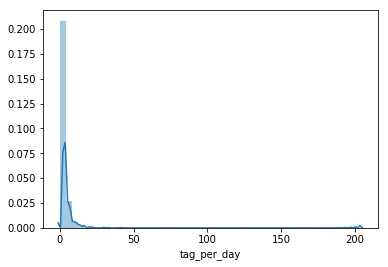

In [128]:
# Visualize the distributions of tag_per_day
sns.distplot(c['tag_per_day'])

Now it's clear to see that, although most of the users' daily created tags are clustered around 5-10, there is indeed a considerable amount of outliers in the `tag_per_day` variable. Whether they are restauran-hired promoters cannot be determined, but we will temporarily remove them for considerations of the most popular restaurant. To determine which group of users are outliers, we use the 1.5 IQR rule.

In [129]:
# Create helper function to determine 1-dimensional outlier and remove them
def find_outlier(data, variable):
    lq,uq=np.percentile(data[variable],[25,75])
    lower_l=lq - 1.5*(uq-lq) 
    upper_l=uq + 1.5*(uq-lq)
    return data[(data[variable] > lower_l)  & (data[variable] < upper_l)]

d = find_outlier(c, 'tag_per_day')

c.count() - d.count()

user_id          116
counts           116
active_period    116
active_day       116
tag_per_day      116
dtype: int64

The elimination only takes out about 116 users, where there are in total roughly 1500 users. 

Other than examining the tags created per day, we also notice that some user has an unusually long active periods. We will not investigate the reason here, as I think longer user time for an app do not appear to be a dubious user behavior. The table will be provided below.

In [108]:
d.sort_values(['active_day'], ascending = False).head(20)

,user_id,counts,active_period,active_day,tag_per_day
1069,1405,59,13864 days 01:15:08,13864,0.0
1269,222,34,13575 days 01:09:52,13575,0.0
1495,422,10,13494 days 22:51:14,13494,0.0
1459,1524,15,13328 days 21:09:06,13328,0.0
1558,17,3,13296 days 03:08:17,13296,0.0
1487,534,11,13250 days 22:53:15,13250,0.0
1518,655,7,12875 days 01:19:49,12875,0.0
1212,468,42,12631 days 02:14:46,12631,0.0
1501,476,9,12561 days 02:34:05,12561,0.0
1403,159,21,12368 days 23:39:11,12368,0.0


### 3.4 Find the most popular restaurants

For the final step, we will find the most popular restaurant based on the same reasoning as part 2: the most tagged restaurant. 

In [130]:
# 3.4 Find the most popular restaurants
# Choose the list of new users in the orginal restaurant df.
restaurant_new = pd.merge(restaurant, d, how = 'inner', left_on = 'user_id', right_on = 'user_id')

# Calculate the restaurant tags
tag_df = restaurant_new.groupby(['postal_code', 'place_id'])['user_id'].agg({'tag':'count'})

# Reset the index to not include postal_code and place_id in the index
tag_df.reset_index(inplace = True)

# Find the restaurant with highest number of user check-ins for each zipcode
(tag_df.groupby('postal_code')['place_id', 'tag'].
     apply(lambda x: x.sort_values(['tag'], ascending = False).head(1)))

/Users/diyangwu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


,,place_id,tag
postal_code,,,
NW5,2,e4074710-967d-42c7-813c-23f16e6dda0d,199
SE22,4,a33cbc9b-8fe3-4984-b6be-de67ea855f81,32086
SW14,34,990af278-006c-419c-abc1-6efa45c60f38,4533
SW15,75,a336dff1-5982-49a6-a70f-8abb47714d7f,4039
SW4,85,0cd46109-3647-4e76-aad4-e7e19e72172b,19392
W11,90,2b2b7930-e0ab-4163-b91f-fc49aada8947,6890
W8,105,96a5b372-590a-4ec3-80ce-7350eaa690ac,164


## Part 4: Machine Learning on Genetic Data

A genetics lab has asked you to build a predictive model of mouse length and weight based on genetic variation.

The genetic data is stored in `part4.csv` with each subject as a row, and each genetic variant as a column. The values indicate the number of copies of the genetic variant they have. Since mice have (in general) 2 copies of each of their chromosomes, the numbers will all be 0, 1, or 2.

Each subject's length (in mm) and weight (in grams) is in the columns labeled `length` and `weight`. 

Study the input and output variables, and determine what drives length and weight.

### Answer

Before building a predictive model on mouse's length and weight, we will first investigate the dataset a little bit to determine what pre-processing is better for the later modeling. 

### 4.1 Read data

In [11]:
# 4.1 Read data:
mouse = pd.read_csv('coding_exercise_data/part4.csv')
mouse.head()

,Unnamed: 0,VARIANT_0000,VARIANT_0001,VARIANT_0002,VARIANT_0003,VARIANT_0004,VARIANT_0005,VARIANT_0006,VARIANT_0007,VARIANT_0008,...,VARIANT_4992,VARIANT_4993,VARIANT_4994,VARIANT_4995,VARIANT_4996,VARIANT_4997,VARIANT_4998,VARIANT_4999,length,weight
0,MOUSE_0000,1,0,0,1,1,1,0,0,0,...,0,2,2,2,2,2,2,2,136.074301,128.438643
1,MOUSE_0001,2,1,2,2,2,2,2,1,1,...,0,2,2,2,2,1,2,2,161.260617,186.424143
2,MOUSE_0002,1,1,1,2,2,2,2,1,1,...,0,2,0,1,0,0,2,1,159.990246,181.324189
3,MOUSE_0003,1,0,1,2,2,2,1,0,0,...,0,2,2,2,1,1,2,2,149.228515,135.048101
4,MOUSE_0004,1,0,1,2,2,2,1,0,1,...,0,2,2,2,1,1,2,1,161.894435,146.067569


In [12]:
mouse.shape

(3000, 5003)

Immediately we see the problem about this dataset. The number of observations/mice is 3000, but the number of genetic variants is roughly 5000. It is typically a huge problem in machine learning that the number of features exceeds the number of observations, which is the so-called curse of dimensionality.

To solve this problem, we either need to do variable elimination or variable extraction. Considering the fact that we are given little information about the internal logic of genetic variants, it is probably not a good idea to try to extract the derived features from the original features. Thus we need to find a way to eliminate some of the not so significant features and thus reduce our dimensionality. 

One method is using Principal Component Analysis(PCA). In short, PCA projects the original data from a high dimension to a lower dimension, while maintaining the maximum amount of variance of the original data. Hopefully after the PCA transformation, the dataset will become more workable.

### 4.2 Data pre-processing

In [156]:
# 4.2 Data pre-processing and PCA
# Extract X and y
# Need to separately treat length and weight variables
X = np.array(mouse.iloc[:, 1:(mouse.shape[1] - 2)].values)

# Outcome variable for length
y_len = np.array(mouse.iloc[:, (mouse.shape[1] - 2)].values)
# Outcome variable for weight
y_wei = np.array(mouse.iloc[:, (mouse.shape[1] - 1)].values)

# Split the training and test set
Xtr_len, Xts_len, ytr_len, yts_len = train_test_split(X, y_len, test_size = 0.2, shuffle=True, random_state = 0)
Xtr_wei, Xts_wei, ytr_wei, yts_wei = train_test_split(X, y_wei, test_size = 0.2, shuffle=True, random_state = 1)

# Standardized Xtr for PCA
def standardize(xtr, xts):
    scaler = StandardScaler()
    scaler.fit(xtr)
    xtr_scale = scaler.transform(xtr)
    xts_scale = scaler.transform(xts)
    return xtr_scale, xts_scale

Xtr_len_scale, Xts_len_scale = standardize(Xtr_len, Xts_len)
Xtr_wei_scale, Xts_wei_scale = standardize(Xtr_wei, Xts_wei)

Text(0,0.5,'cumulative explained variance')

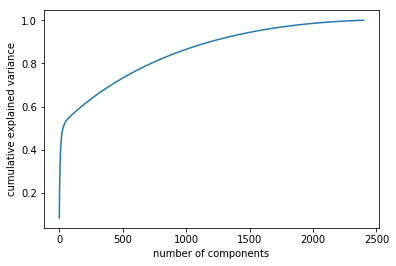

In [16]:
# fit PCA to Xtr; make graphs to show proportion of variance captured

pca = PCA().fit(Xtr_len_scale)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Above is a graph to represent number of components vs. explained variance tradeoff. In general, it's true that the more variance you want to capture, the more components you have to include in the model. Thus we should find a cut-off point where a decent amount of variance will be explained and the number of components is also reduced.

In [490]:
pca = PCA(0.6).fit(Xtr_scale)
pca.n_components_

176

If we choose 60% of variance to be explained, 176 variables will be included. This seems workable.

In [153]:
# fit PCA to both Xtr and Xts
# helper function to use PCA transformation
def pcatransform(xtr, xts):
    pca = PCA(0.6)
    pca.fit(xtr)
    xtr_pca = pca.transform(xtr)
    xts_pca = pca.transform(xts)
    return xtr_pca, xts_pca

Xtr_len_pca, Xts_len_pca = pcatransform(Xtr_len_scale, Xts_len_scale)
Xtr_wei_pca, Xts_wei_pca = pcatransform(Xtr_wei_scale, Xts_wei_scale)

### 4.3 Model building: Linear Regression

After using PCA to transform our data, it is time to fit our newly generated low_dimensional data to a model.

The first model we try here is a linear regression. Although it is an extremely simple model compared to the other state-of-the-art techniques, linear regression can offer some easy and interpretable results. Thus it is always not bad to start from this model.

The metrics we will be using for this regresison problem is $R^2$ score. In short, $R^2$ measures how much of the relationship between your X variable and y variable is explained by your model estimation, versus estimating y variable using its mean. $R^2$ ranges from 0 to 1; if it's close to 1, it means your model fits the data well; if it's close to 0, it means your model is similar to just estimating y variable with its mean. 

In [154]:
# 4.3 Model building: Linear Regression
# Prediciting length
lr = LinearRegression()
lr.fit(Xtr_len_pca, ytr_len)
lr.score(Xts_len_pca, yts_len)

0.40080449280438923

In [155]:
# Predicting weight
lr.fit(Xtr_wei_pca, ytr_wei)
lr.score(Xts_wei_pca, yts_wei)

0.1444733949453746

As we see, the results from a linear regression is not that impressive, especially for predicting the `weight` variable with the $R^2$ being 0.14. Perhaps the inherent relationship between the genetic variants to the mice's lengths and weights are not linear. Thus we need to switch to another model.

### 4.4 Model building: Random Forest

One of the hottest machine learning algorithms in industry nowadays is Random Forest. This is a tree-based algorithm, where in the forest every tree sees a subset of features, uses a sample of the original data, and makes its own decision. The final outcome of the Random  Forest regression will be the average of every tree. 

I choose to use this model here because Random Forest is not bothered as much encountering high-dimensional data as other models. For this model I will use method of Random Search to tune the hyperparameters of random forest, and print out the best model result with a set of hyperparameters.

In [157]:
# 4.4 Model building: Random Forest combined with Random Search
# helper function for printing out search results 
def print_random_search_metrics(rs):
    print ("Best score: %0.3f" % rs.best_score_)
    print ("Best parameters set:")
    best_parameters = rs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %s" % (param_name, best_parameters[param_name]))

In [26]:
# Possible hyperparamter options for Random Forest
parameters = {
    'n_estimators' : [80,90],
    'max_features' : ['auto','sqrt','log2'],
    'min_samples_leaf' : [1,10,50,100]
}

# Using Random Search to find the best hyperparameters for Random Forest regression
Random_RF = RandomizedSearchCV(RandomForestRegressor(),parameters, cv=5)
Random_RF.fit(Xtr_len_pca, ytr_len)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=N

In [27]:
# Model result
print_random_search_metrics(Random_RF)

Best score: 0.270
Best parameters set:
	max_features: auto
	min_samples_leaf: 10
	n_estimators: 80


$R^2$ for just training data and with best hyperparameter under Random Forest regression is only 0.27, even worse than the previous linear regression. 

At this point, we should ask ourselves, instead of changing other models to fit in our data, should we redirect our strategies? Maybe the idea of using PCA to reduce the dimensionality is not appropriate in the first place. 

Although every genetic variant, our x variable, is continuous, the variance of it is not much because each variable only contains three values. However, the whole point of using PCA is to capture the maximum variance of the original data. Maybe the data after PCA transformation is not representitive of the original data at all beacause there is not much of variance to be captured. Maybe it's the case that other latent features in our x variable are crucial in predicting length and weight, but somehow were lost after PCA transformation.

### 4.5 Model building: Lasso Regression

The other technique we can try for dimensionality reduction is regularization. This method forces to shrink the coefficients of x variables by adding a penalty term in the loss function. In other words, regularization will make the coefficients of insignificant variables to be close to 0, and thus filtering out them. 

For this problem, we will use the Lasso regression as the regularization technique. Be mindful that, in the later code we fit Lasso regression with different penalty coefficients. Generally, the higher the penalty coefficients, the more restricted/less variables left in the model. The model results will be graphed.

In [47]:
# 4.5 Model building: Lasso Regression
# helper function to fit lasso regresison with different alpha
# make graphs of the results 
def lassoregression(Xtr, ytr, Xts, yts):
    alpha = np.linspace(0.1, 1, 10)
    train_score = []
    test_score = []
    for i in range(10):
        ls = Lasso(alpha = alpha[i], max_iter = 10000, tol = 1e-10)
        ls.fit(Xtr, ytr)
        train_score = np.append(train_score, ls.score(Xtr, ytr))
        test_score = np.append(test_score, ls.score(Xts, yts))
    plt.figure(figsize=(9,5))
    plt.scatter(alpha,train_score,label='train_score')
    plt.plot(alpha,train_score)
    plt.scatter(alpha,test_score,label='test_score')
    plt.plot(alpha,test_score)
    plt.ylim((min(test_score) - 0.1),1)
    plt.xlim(0,1.1)
    plt.xlabel('alpha', size = 14)
    plt.ylabel('score',size = 14)
    plt.legend()
    plt.show()    

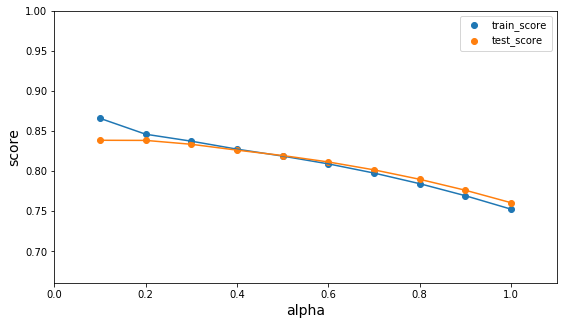

In [48]:
# predicting length
lassoregression(Xtr_len, ytr_len, Xts_len, yts_len)

/Users/diyangwu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.651188168674707, tolerance: 0.00016349361710662585
  positive)


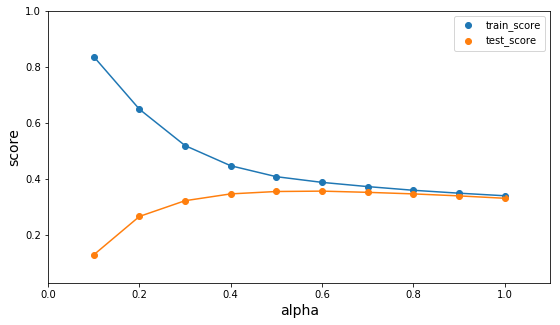

In [49]:
# predicting weight
lassoregression(Xtr_wei, ytr_wei, Xts_wei, yts_wei)

As we see from above, surprisingly a simple Lasso regression boosts our $R^2$ for predicting `length` variable to around 0.85, more than doubled to the linear regression. The performance of predicting `weight` variable is not as good, with a $R^2$ variable being around 0.4. However, it's still better than dealing with PCA data.

###  4.6 Model Interpretation

In [163]:
# 4.6 Model intepretation
# Helper function to print results of best model performance with appropriate alpha
def printlasso(Xtr, ytr, Xts, yts, alpha):
    ls = Lasso(alpha = alpha)
    ls.fit(Xtr, ytr)
    train_score = ls.score(Xtr, ytr)
    test_score = ls.score(Xts, yts)
    important_feature = np.where(ls.coef_ != 0)
    print('The results for lasso regression under alpha level {}:'.format(alpha))
    print('The train score is {}'.format(train_score))
    print('The train score is {}'.format(test_score))
    print('The list of significant genetic variants number is %s' % important_feature)

In [164]:
# Predicting length
printlasso(Xtr_len, ytr_len, Xts_len, yts_len, 0.2)

The results for lasso regression under alpha level 0.2:
The train score is 0.8461380347169623
The train score is 0.838456691440833
The list of significant genetic variants number is [  25   39 1029 1146 1945 1999 2022 2182 2209 2222 2401 2892 2918 3199
 3224 3339 3692 3914 4101 4256 4345 4681 4719 4733 4746 4848 4880 4923
 4957 4986]


In [165]:
# Predicting weight
printlasso(Xtr_wei, ytr_wei, Xts_wei, yts_wei, 0.6)

The results for lasso regression under alpha level 0.6:
The train score is 0.387043063889412
The train score is 0.35570888252278704
The list of significant genetic variants number is [  25   72   94  240  338  352  438  586  628  698  898  902  941 1146
 1150 1217 1407 1444 1574 1618 1699 1753 1797 1939 1945 1977 1999 2388
 2495 2612 2664 3153 3210 3397 3432 3569 3601 3641 3659 3688 3692 3704
 3733 3755 3780 3808 3823 3826 3893 3914 3970 4021 4101 4136 4383 4437
 4451 4495 4554 4632 4646 4697 4728 4857 4880 4956]


As we see from above, the model performances as well as the list of significant variables(with coefficient not being 0) are printed. Performance of predicting length is really good considering Lasso regression is a relativelt simple model, with both training and test $R^2$ being more than 0.8. The performance of predicting weight is not as good with $R^2$ being around 0.35. 

One key question for this problem is what drives the mice's length and weight. Here we provide the list of statistically significant genetic variants output from this model. However, despite the good model performance, those variables filtered from our regression are only potentially important as they are recognized not as 0 importance of predicting the outcomes. The actual relationship between genetic variants and outcomes need to be further investigated based on rigourous biological and genetic studies. This list only serves to provide some insights to the researchers, instead of determining 'what drives outcomes'.

Another thing to be noticed is that the model performance of predicting `weight` is consistently lower than predicting `length` in both modeling setups. This might suggest a finding that, genetic variant effects length more than it does  to weight. There are probably more outside factors such as diet and environments to influence the mice's weight, whereas length is less volatile due to those factors. But again, these are only assumptions made based on our model output. The real mechanism behind the data should be rigorously studied by researchers.